In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, VBox, Label, IntText, Output
import tifffile as tiff
import os

In [4]:
### New version
class CellLabeler:
    def __init__(self, features_df, image_paths, mask_paths):
        self.df = features_df.copy()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.current_idx = 0
        self.labels = np.full(len(self.df), -1, dtype=int)  # -1 = unlabeled
        
        # Create widgets
        self.img_output = Output()
        self.label_buttons = HBox([
            Button(description='Healthy (0)', button_style='success'),
            Button(description='Unhealthy (1)', button_style='danger'),
            Button(description='Mitotic (2)', button_style='info'),
            Button(description='Weird (3)', button_style='primary'),
            Button(description='Unsure (Skip)', button_style='warning')
        ])
        self.counter = IntText(value=0, description='Labeled:')
        self.progress = Label(f"Progress: 0/{len(self.df)}")
        
        # Set up callbacks
        self.label_buttons.children[0].on_click(self._label_healthy)
        self.label_buttons.children[1].on_click(self._label_unhealthy)
        self.label_buttons.children[2].on_click(self._label_mitotic)
        self.label_buttons.children[3].on_click(self._label_weird)
        self.label_buttons.children[4].on_click(self._next_cell)
        
        # Display initial cell
        self._show_current_cell()

    def _show_current_cell(self):
        with self.img_output:
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
            # Load raw image (handle 3D stacks)
            img = tiff.imread(self.image_paths[self.current_idx])
            if img.ndim == 3:  # If multi-page TIFF
                img = img[0]  # Take first slice, or use img.max(axis=0)
            ax1.imshow(img.squeeze(), cmap='gray')  # Remove singleton dimensions
            ax1.set_title(f"Cell {self.current_idx} - Raw Image")
            
            # Load mask (handle label matrices)
            mask = tiff.imread(self.mask_paths[self.current_idx])
            if mask.ndim == 3:  # If multi-page TIFF
                mask = mask[0]
            
            # Convert label matrix to binary (optional)
            binary_mask = (mask > 0).astype(np.uint8)
            
            ax2.imshow(mask.squeeze(), cmap='viridis', vmin=0, vmax=mask.max())
            ax2.set_title("Segmentation Mask (Track IDs)")
            
            plt.show()
            display(self.df.iloc[self.current_idx].to_frame().T)

    def _update_label(self, label):
        self.labels[self.current_idx] = label
        self.counter.value = sum(self.labels != -1)
        self.progress.value = f"Progress: {self.counter.value}/{len(self.df)}"
        self._next_cell()
        
    def _label_healthy(self, btn):
        self._update_label(0)
        
    def _label_unhealthy(self, btn):
        self._update_label(1)
        
    def _label_mitotic(self, btn):
        self._update_label(2)
        
    def _label_weird(self, btn):
        self._update_label(3)
        
    def _next_cell(self, btn=None):
        self.current_idx = (self.current_idx + 1) % len(self.df)
        self._show_current_cell()
        
    def show(self):
        display(VBox([self.img_output, self.label_buttons, self.counter, self.progress]))
        
    def get_labels(self):
        return self.labels

def structured_sort_key(filepath):
    filename = os.path.splitext(os.path.basename(filepath))[0]
    parts = filename.split('_')
    
    # Extract numbers from relevant parts
    exp_num = int(parts[1][3:])    # Extract from "ExpXX"
    site_num = int(parts[2][4:])   # Extract from "SiteXX"
    seq_num = int(parts[3])       # Trailing number
    
    return (exp_num, site_num, seq_num)

In [2]:
class CellLabeler:
    def __init__(self, features_df, image_paths, mask_paths):
        self.df = features_df.copy()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.current_idx = 0
        self.labels = np.full(len(self.df), -1, dtype=int)  # -1 = unlabeled
        
        # Create widgets
        self.img_output = Output()
        self.label_buttons = HBox([
            Button(description='Healthy (0)', button_style='success'),
            Button(description='Unhealthy (1)', button_style='danger'),
            Button(description='Unsure (Skip)', button_style='warning')
        ])
        self.counter = IntText(value=0, description='Labeled:')
        self.progress = Label(f"Progress: 0/{len(self.df)}")
        
        # Set up callbacks
        self.label_buttons.children[0].on_click(self._label_healthy)
        self.label_buttons.children[1].on_click(self._label_unhealthy)
        self.label_buttons.children[2].on_click(self._next_cell)
        
        # Display initial cell
        self._show_current_cell()

    def _show_current_cell(self):
        with self.img_output:
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            
            # Load raw image (handle 3D stacks)
            img = tiff.imread(self.image_paths[self.current_idx])
            if img.ndim == 3:  # If multi-page TIFF
                img = img[0]  # Take first slice, or use img.max(axis=0)
            ax1.imshow(img.squeeze(), cmap='gray')  # Remove singleton dimensions
            ax1.set_title(f"Cell {self.current_idx} - Raw Image")
            
            # Load mask (handle label matrices)
            mask = tiff.imread(self.mask_paths[self.current_idx])
            if mask.ndim == 3:  # If multi-page TIFF
                mask = mask[0]
            
            # Convert label matrix to binary (optional)
            binary_mask = (mask > 0).astype(np.uint8)
            
            ax2.imshow(mask.squeeze(), cmap='viridis', vmin=0, vmax=mask.max())
            ax2.set_title("Segmentation Mask (Track IDs)")
            
            plt.show()
            display(self.df.iloc[self.current_idx].to_frame().T)

            
    def _update_label(self, label):
        self.labels[self.current_idx] = label
        self.counter.value = sum(self.labels != -1)
        self.progress.value = f"Progress: {self.counter.value}/{len(self.df)}"
        self._next_cell()
        
    def _label_healthy(self, btn):
        self._update_label(0)
        
    def _label_unhealthy(self, btn):
        self._update_label(1)
        
    def _next_cell(self, btn=None):
        self.current_idx = (self.current_idx + 1) % len(self.df)
        self._show_current_cell()
        
    def show(self):
        display(VBox([self.img_output, self.label_buttons, self.counter, self.progress]))
        
    def get_labels(self):
        return self.labels



In [21]:
features_df = pd.read_csv("/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/features.csv")

In [5]:
# Usage example
BASE_DIR = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df'
features_df = pd.read_csv("/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/features.csv")  # From previous analysis
image_paths = sorted(
    [os.path.join(BASE_DIR, "raw_images", f) 
     for f in os.listdir(f"{BASE_DIR}/raw_images")],
    key=structured_sort_key
)
mask_paths = sorted(
    [os.path.join(BASE_DIR, "masks", f) 
     for f in os.listdir(f"{BASE_DIR}/masks")],
    key=structured_sort_key
)



labeler = CellLabeler(features_df, image_paths, mask_paths)
labeler.show()

In [9]:
# Usage example
BASE_DIR = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df'
features_df = pd.read_csv("/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/features.csv")  # From previous analysis
image_paths = sorted([os.path.join(BASE_DIR, "raw_images", f) for f in os.listdir(f"{BASE_DIR}/raw_images")])
mask_paths = sorted([os.path.join(BASE_DIR, "masks", f) for f in os.listdir(f"{BASE_DIR}/masks")])

labeler = CellLabeler(features_df, image_paths, mask_paths)
labeler.show()

In [6]:
labels = labeler.get_labels()
print(labels)
labeled_df = features_df[['label', 'x', 'y', 't', 'filename']].copy()
labeled_df['status'] = labels
print(labeled_df)

[-1  0  0 ...  1 -1  1]
       label      x      y       t                    filename  status
0        2.0  678.0  688.0     0.0     cell_Exp01_Site01_2.tif      -1
1        3.0   70.0  678.0     0.0     cell_Exp01_Site01_3.tif       0
2        4.0  282.0  680.0     0.0     cell_Exp01_Site01_4.tif       0
3        5.0  106.0  680.0     0.0     cell_Exp01_Site01_5.tif       0
4        6.0  400.0  682.0     0.0     cell_Exp01_Site01_6.tif       0
...      ...    ...    ...     ...                         ...     ...
1090  5269.0  406.0   98.0  1359.0  cell_Exp01_Site02_5269.tif       1
1091  5321.0  236.0  600.0  1372.0  cell_Exp01_Site02_5321.tif      -1
1092  5362.0  746.0  488.0  1382.0  cell_Exp01_Site02_5362.tif       1
1093  5399.0  944.0  172.0  1391.0  cell_Exp01_Site02_5399.tif      -1
1094  5443.0  344.0  270.0  1402.0  cell_Exp01_Site02_5443.tif       1

[1095 rows x 6 columns]


In [12]:
clean_labels = labeled_df[labeled_df['status'] != -1]

In [14]:
print(clean_labels[clean_labels['status'] != -1])

       label      x      y       t                    filename  status
1        3.0   70.0  678.0     0.0     cell_Exp01_Site01_3.tif       0
2        4.0  282.0  680.0     0.0     cell_Exp01_Site01_4.tif       0
3        5.0  106.0  680.0     0.0     cell_Exp01_Site01_5.tif       0
4        6.0  400.0  682.0     0.0     cell_Exp01_Site01_6.tif       0
5        7.0  130.0  670.0     0.0     cell_Exp01_Site01_7.tif       0
...      ...    ...    ...     ...                         ...     ...
1082  5038.0  532.0  392.0  1300.0  cell_Exp01_Site02_5038.tif       0
1087  5254.0  876.0  268.0  1354.0  cell_Exp01_Site02_5254.tif       3
1090  5269.0  406.0   98.0  1359.0  cell_Exp01_Site02_5269.tif       1
1092  5362.0  746.0  488.0  1382.0  cell_Exp01_Site02_5362.tif       1
1094  5443.0  344.0  270.0  1402.0  cell_Exp01_Site02_5443.tif       1

[764 rows x 6 columns]


In [17]:
import os
import tifffile as tiff
import pandas as pd
from skimage.measure import regionprops_table

# Configuration
PROPERTIES = [
    'area', 'perimeter', 'bbox_area', 'convex_area', 'eccentricity',
    'equivalent_diameter', 'extent', 'feret_diameter_max', 'major_axis_length',
    'minor_axis_length', 'orientation', 'solidity', 'intensity_mean',
    'intensity_std', 'intensity_max', 'intensity_min', 'moments_hu'
]

# Initialize list to store features
features_list = []

# Iterate through annotated cells
for idx, row in labeled_df.iterrows():
    # Load mask and image
    mask_path = os.path.join(BASE_DIR, "masks", row['filename'])
    img_path = os.path.join(BASE_DIR, "raw_images", row['filename'])
    
    masks = tiff.imread(mask_path)
    imgs = tiff.imread(img_path)

    current_features = []
    for mask, img in zip(masks,imgs):    
        # Calculate features (KEY FIX: use mask/img variables)
        features = regionprops_table(
            label_image=mask.astype(int),  # Ensure integer type
            intensity_image=img,
            properties=PROPERTIES
        )
        feature_df = pd.DataFrame(features)
        if not feature_df.empty:
            current_features.append(feature_df)

    if current_features:
        current_features_df = pd.concat(current_features, ignore_index=True)
        mean_features = current_features_df.mean()
        features_list.append(mean_features)
    

# Convert to DataFrame and merge
features_df = pd.DataFrame(features_list)
final_df = pd.concat([labeled_df.reset_index(drop=True), 
                     features_df.reset_index(drop=True)], axis=1)

final_df.to_csv("/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/labeled_cells.csv", index=False)


# Verify
print(f"Original rows: {len(labeled_df)}")
print(f"New features: {features_df.shape}")
print(final_df.head())

Original rows: 1095
New features: (1095, 23)
   label      x      y    t                 filename  status   area  \
0    2.0  678.0  688.0  0.0  cell_Exp01_Site01_2.tif      -1  921.8   
1    3.0   70.0  678.0  0.0  cell_Exp01_Site01_3.tif       0  535.8   
2    4.0  282.0  680.0  0.0  cell_Exp01_Site01_4.tif       0  868.4   
3    5.0  106.0  680.0  0.0  cell_Exp01_Site01_5.tif       0  940.0   
4    6.0  400.0  682.0  0.0  cell_Exp01_Site01_6.tif       0  969.2   

    perimeter  bbox_area  convex_area  ...  intensity_std  intensity_max  \
0  113.914127     1252.4        951.2  ...     552.605089         3617.0   
1   87.412193      729.0        559.0  ...     317.459238         2278.6   
2  110.499913     1192.6        892.0  ...     384.001099         2650.4   
3  113.105801     1217.2        966.2  ...     608.736882         4469.0   
4  117.142554     1338.0        996.0  ...     264.374967         2065.6   

   intensity_min  moments_hu-0  moments_hu-1  moments_hu-2  moments_hu-

In [4]:
# With additional options
df = pd.read_csv('/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/labeled_cells.csv', 
                 sep=',',           # specify separator 
                 header=0,           # use first row as column names
                 index_col=None)     # optional: specify index column


final_df = df[df['status'] != -1]

In [20]:
final_df

,label,x,y,t,filename,status,area,perimeter,bbox_area,convex_area,...,intensity_std,intensity_max,intensity_min,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6
0,2.0,678.0,688.0,0.0,cell_Exp01_Site01_2.tif,-1,921.8,113.914127,1252.4,951.2,...,552.605089,3617.0,884.0,0.163231,0.000186,0.000331,9.054044e-07,1.753182e-11,1.187687e-08,-1.114507e-11
1,3.0,70.0,678.0,0.0,cell_Exp01_Site01_3.tif,0,535.8,87.412193,729.0,559.0,...,317.459238,2278.6,855.6,0.171464,0.003521,0.000136,4.362647e-06,1.382096e-10,1.527975e-07,8.814754e-11
2,4.0,282.0,680.0,0.0,cell_Exp01_Site01_4.tif,0,868.4,110.499913,1192.6,892.0,...,384.001099,2650.4,759.6,0.169753,0.003228,0.000074,2.460770e-06,2.144543e-11,7.548227e-08,3.260414e-11
3,5.0,106.0,680.0,0.0,cell_Exp01_Site01_5.tif,0,940.0,113.105801,1217.2,966.2,...,608.736882,4469.0,1030.4,0.160535,0.000217,0.000045,8.770938e-08,1.581615e-13,7.753135e-10,-1.534724e-13
4,6.0,400.0,682.0,0.0,cell_Exp01_Site01_6.tif,0,969.2,117.142554,1338.0,996.0,...,264.374967,2065.6,493.0,0.170988,0.003669,0.000059,2.492890e-06,2.335440e-11,6.143144e-08,-5.446163e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,5269.0,406.0,98.0,1359.0,cell_Exp01_Site02_5269.tif,1,700.0,113.340115,1194.0,780.0,...,122.794174,1001.8,359.6,0.220666,0.018823,0.001790,1.936200e-04,1.925138e-09,-5.734333e-06,1.210866e-07
1091,5321.0,236.0,600.0,1372.0,cell_Exp01_Site02_5321.tif,-1,298.6,68.035743,417.4,326.4,...,209.830985,1473.0,555.6,0.188545,0.008490,0.000350,3.002426e-05,-3.048484e-09,-3.288363e-07,-5.071149e-09
1092,5362.0,746.0,488.0,1382.0,cell_Exp01_Site02_5362.tif,1,1109.8,128.334228,1513.2,1151.2,...,272.465051,1809.6,392.6,0.171052,0.002338,0.000447,9.982722e-06,-1.707810e-10,-1.222368e-07,-3.737063e-10
1093,5399.0,944.0,172.0,1391.0,cell_Exp01_Site02_5399.tif,-1,780.0,109.177879,990.6,811.0,...,164.229309,1530.4,395.8,0.178521,0.006027,0.000066,5.527155e-06,1.495693e-10,3.980034e-07,-5.228958e-11


In [31]:
from sklearn.feature_selection import f_classif

final_df_filt = final_df[final_df['status'] != -1]

X = final_df_filt.drop(columns=['label', 'filename', 'status'])  # Features
y = final_df_filt['status']  # Labels (0=healthy, 1=unhealthy)

# Calculate ANOVA F-values
f_scores, p_values = f_classif(X, y)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values('F_score', ascending=False)

print(feature_importance.head(10))

                Feature     F_score        p_value
8   equivalent_diameter  253.023385  7.985197e-114
4             perimeter  221.731312  2.600279e-103
12    minor_axis_length  199.209228   2.617145e-95
11    major_axis_length  196.985298   1.696224e-94
10   feret_diameter_max  189.768851   7.780437e-92
5             bbox_area  186.521011   1.267559e-90
3                  area  185.139691   4.179507e-90
6           convex_area  182.199995   5.361513e-89
14             solidity  165.165221   2.000514e-82
2                     t   89.380041   1.519933e-49


In [32]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
feature_importance['MI_score'] = mi_scores
feature_importance = feature_importance.sort_values('MI_score', ascending=False)


In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

feature_importance['RF_importance'] = model.feature_importances_
feature_importance = feature_importance.sort_values('RF_importance', ascending=False)

In [34]:
print(feature_importance)

                Feature     F_score        p_value  MI_score  RF_importance
22         moments_hu-3   50.448688   9.666197e-30  0.306546       0.099825
19         moments_hu-0   53.943087   1.287092e-31  0.272186       0.096094
3                  area  185.139691   4.179507e-90  0.315625       0.073626
10   feret_diameter_max  189.768851   7.780437e-92  0.302891       0.073292
21         moments_hu-2   51.275997   3.461953e-30  0.278268       0.067177
0                     x    1.040054   3.741104e-01  0.118657       0.065627
13          orientation    0.663924   5.743864e-01  0.119600       0.045796
15       intensity_mean    3.427238   1.678961e-02  0.087009       0.042805
1                     y    1.509804   2.106074e-01  0.122265       0.038854
5             bbox_area  186.521011   1.267559e-90  0.285855       0.037653
9                extent   45.732611   3.546266e-27  0.034828       0.035180
17        intensity_max   23.519871   1.450906e-14  0.070196       0.032455
6           

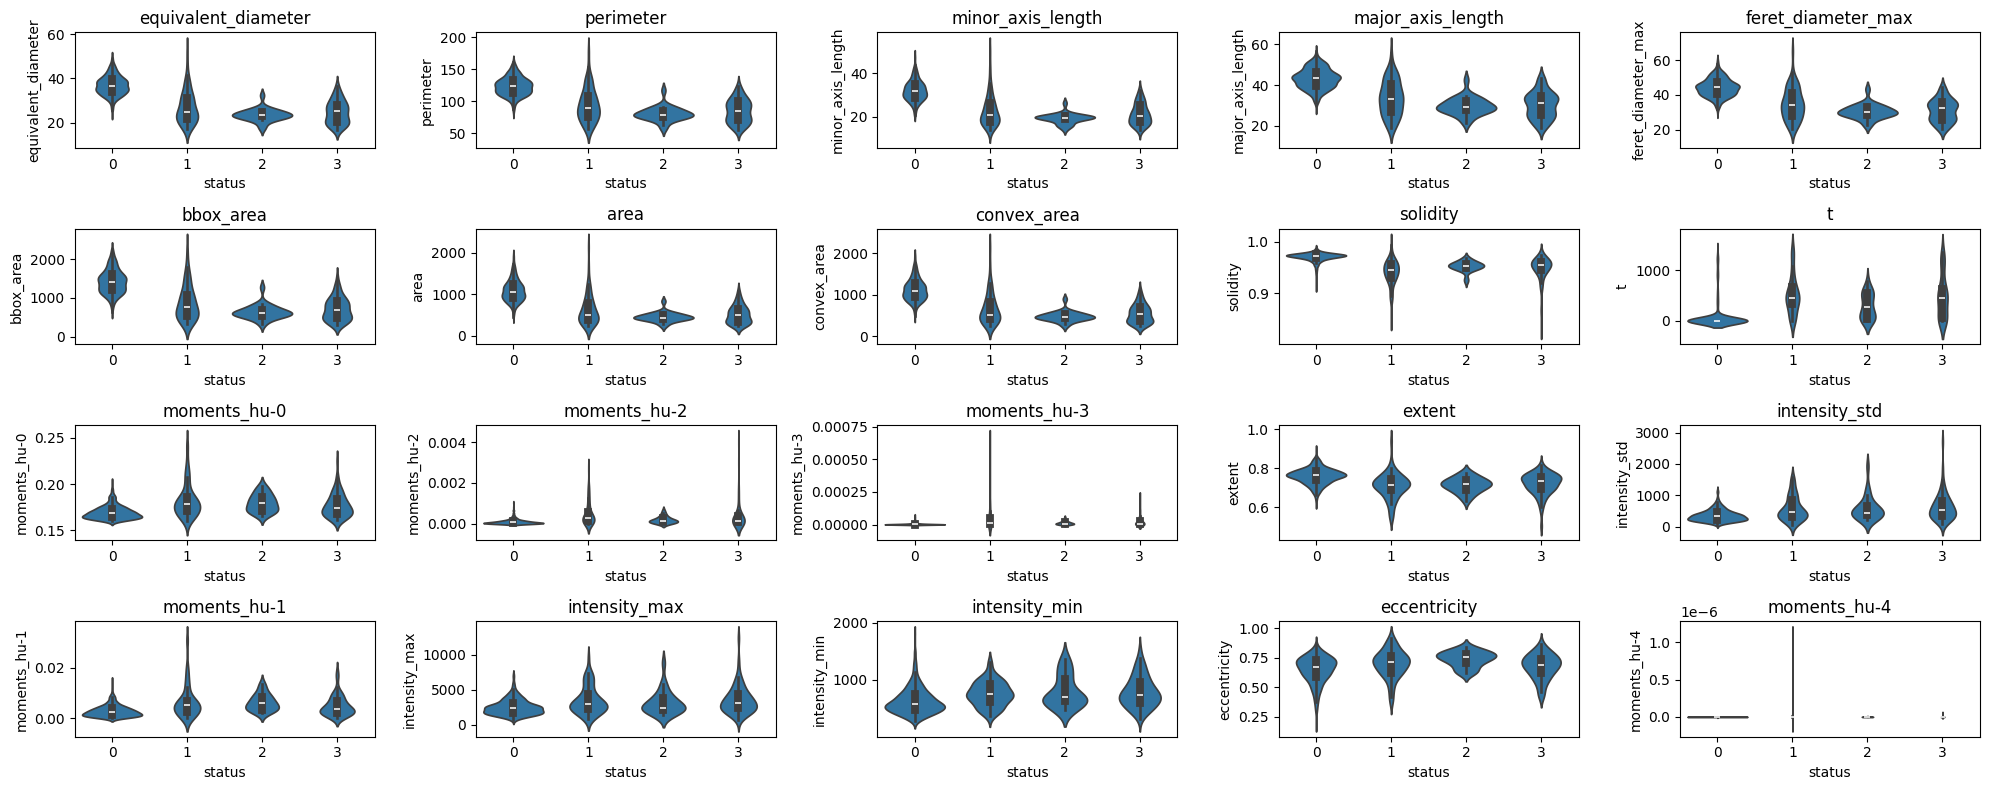

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance = feature_importance.sort_values('F_score', ascending=False)

top_features = feature_importance.head(20)['Feature'].tolist()  # Get top 10 features

fig, axes = plt.subplots(4, 5, figsize=(20, 8))  # Create a 2-row, 5-column grid
axes = axes.flatten()  # Flatten axes array for easy iteration

for ax, feat in zip(axes, top_features):
    sns.violinplot(x='status', y=feat, data=final_df_filt, ax=ax)
    ax.set_title(feat)

plt.tight_layout()
plt.show()

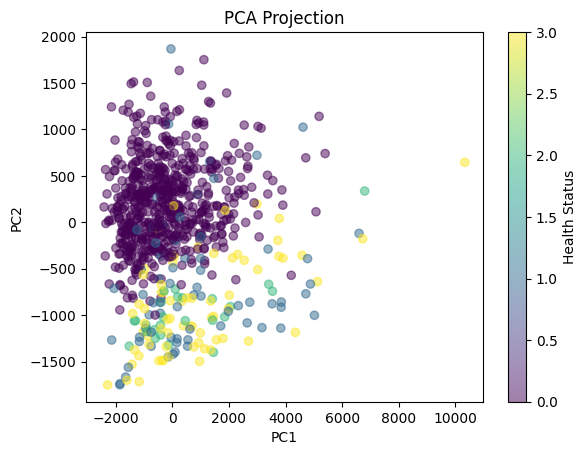

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection')
plt.colorbar(label='Health Status')

Text(0.5, 1.0, 'Feature Correlation Matrix')

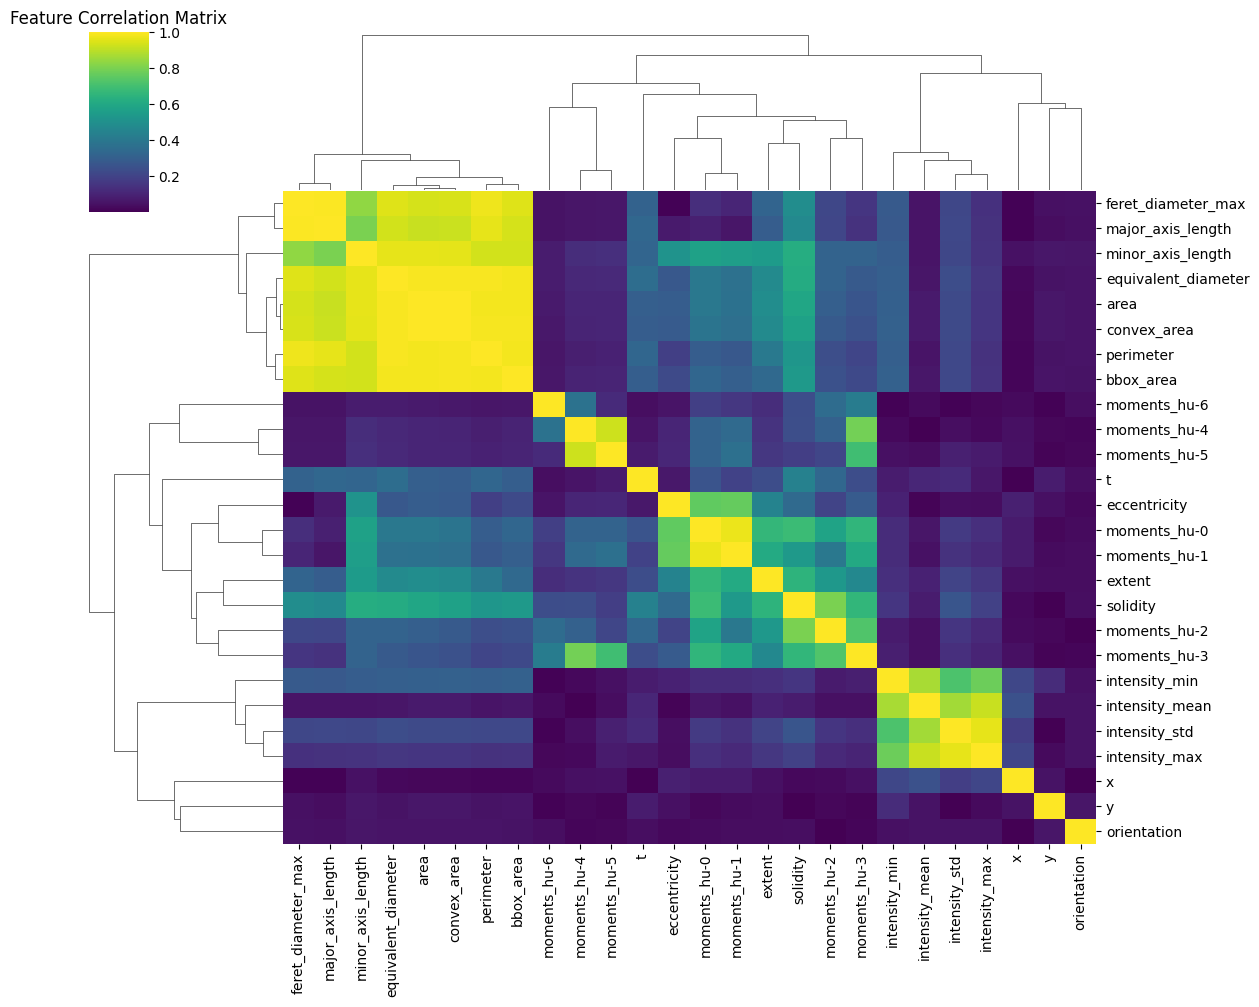

In [42]:
corr_matrix = X.corr()
sns.clustermap(corr_matrix.abs(), cmap='viridis', figsize=(12, 10))
plt.title('Feature Correlation Matrix')

In [15]:
print(feature_importance)

                Feature   F_score   p_value  MI_score  RF_importance
3                  area  3.453163  0.063450  0.000977       0.049383
7          eccentricity  0.000529  0.981663  0.022841       0.046413
11    major_axis_length  4.486094  0.034439  0.002996       0.046263
8   equivalent_diameter  3.858839  0.049785  0.000000       0.045291
10   feret_diameter_max  4.061605  0.044159  0.023436       0.045144
24         moments_hu-5  0.804531  0.369976  0.024687       0.044185
15       intensity_mean  0.057013  0.811335  0.000133       0.044114
14             solidity  0.173325  0.677270  0.000000       0.043374
23         moments_hu-4  0.890715  0.345531  0.000000       0.042512
9                extent  1.025115  0.311575  0.000000       0.041938
13          orientation  0.072269  0.788121  0.000000       0.041478
25         moments_hu-6  0.566650  0.451786  0.000000       0.041270
6           convex_area  3.626918  0.057163  0.000000       0.040013
19         moments_hu-0  0.063975 

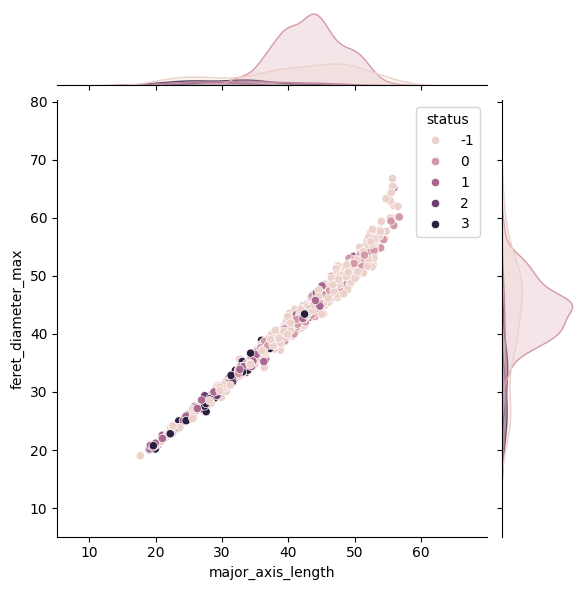

In [43]:
sns.jointplot(data=final_df, x='major_axis_length', y='feret_diameter_max', hue='status')

In [16]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = XGBClassifier()
model.fit(X_train, y_train)
print(f"Accuracy: {model.score(X_test, y_test):.2f}")

ModuleNotFoundError: No module named 'xgboost'

In [4]:
import pandas as pd

In [5]:
# With additional options
df = pd.read_csv('/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/labeled_cells.csv', 
                 sep=',',           # specify separator 
                 header=0,           # use first row as column names
                 index_col=None)     # optional: specify index column

img_dir = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/raw_images'

In [10]:
import os
import shutil

# Define the source directory (where your raw images are) and the destination base folder.
source_dir = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/raw_images'
destination_base = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/raw_imgs_separate'

# Create destination base directory if it doesn't exist.
os.makedirs(destination_base, exist_ok=True)

# Loop over your statuses (for example, -1 to 3; adjust as needed)
for status in range(-1, 4):
    # Create a directory for each status inside the destination base
    status_dir = os.path.join(destination_base, str(status))
    os.makedirs(status_dir, exist_ok=True)

    # Filter the dataframe for the current status
    current_data = df[df['status'] == status]
    print(f"Processing status: {status}")

    for index, row in current_data.iterrows():
        # Assume 'filename' contains the relative or absolute path of the file
        filename = row['filename']
        
        source_file = os.path.join(source_dir, filename)

        # Copy the file to the destination directory
        destination_file = os.path.join(status_dir, filename)
        shutil.copy(source_file, destination_file)


Processing status: -1
Processing status: 0
Processing status: 1
Processing status: 2
Processing status: 3


In [11]:
import os
import shutil

# Define the source directory (where your raw images are) and the destination base folder.
source_dir = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/masks'
destination_base = '/home/nbahou/myimaging/apoDet/data/test_health_filter/features_df/masks_separate'

# Create destination base directory if it doesn't exist.
os.makedirs(destination_base, exist_ok=True)

# Loop over your statuses (for example, -1 to 3; adjust as needed)
for status in range(-1, 4):
    # Create a directory for each status inside the destination base
    status_dir = os.path.join(destination_base, str(status))
    os.makedirs(status_dir, exist_ok=True)

    # Filter the dataframe for the current status
    current_data = df[df['status'] == status]
    print(f"Processing status: {status}")

    for index, row in current_data.iterrows():
        # Assume 'filename' contains the relative or absolute path of the file
        filename = row['filename']
        
        source_file = os.path.join(source_dir, filename)

        # Copy the file to the destination directory
        destination_file = os.path.join(status_dir, filename)
        shutil.copy(source_file, destination_file)


Processing status: -1
Processing status: 0
Processing status: 1
Processing status: 2
Processing status: 3


label      x      y    t                 filename  status   area  \
0    2.0  678.0  688.0  0.0  cell_Exp01_Site01_2.tif      -1  921.8   
1    3.0   70.0  678.0  0.0  cell_Exp01_Site01_3.tif       0  535.8   
2    4.0  282.0  680.0  0.0  cell_Exp01_Site01_4.tif       0  868.4   
3    5.0  106.0  680.0  0.0  cell_Exp01_Site01_5.tif       0  940.0   
4    6.0  400.0  682.0  0.0  cell_Exp01_Site01_6.tif       0  969.2   

In [ ]:
filenames = clean_labels['filename']
features_list = []



for name in filenames:
    mask = tiff.imread(os.path.join(BASE_DIR, "masks", name))
    img = tiff.imread(os.path.join(BASE_DIR, "raw_images", name))

    features = regionprops_table(
        label_image=mask, 
        intensity_image=img,
        properties=PROPERTIES
    )

    features_list.append(features)

features_df = pd.DataFrame(features_list)






In [ ]:
from skimage.measure import regionprops_table



# Get all features for your masks
features = regionprops_table(
    label_image=masks, 
    intensity_image=raw_image,
    properties=PROPERTIES
)
df = pd.DataFrame(features)

In [ ]:
# After labeling
labels = labeler.get_labels()
labeled_df = features_df.copy()
labeled_df['label'] = labels
labeled_df.to_csv("labeled_cells.csv", index=False)

# Filter out skipped cells (-1 labels)
clean_labels = labeled_df[labeled_df['label'] != -1]